# 3.2 Aplicação de Léxicos

### Loading e Tratamento de Duplicados

In [ ]:
import nltk
import pandas as pd
from collections import Counter
import re
import itertools

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

Loading dos datasets como dataframes

In [383]:
train_df = pd.read_csv("./imdb_reviews_train.csv", encoding="utf-8")
test_df = pd.read_csv("./imdb_reviews_test.csv", encoding="utf-8")

In [57]:
# Check Duplicates

def dupes(df):
    dup = df.duplicated(keep=False).sum()
    print(f"Duplicates found: {dup}") 
    if dup > 0:
        df = df.drop_duplicates()
        print(f"Number of duplicates after removal: {df.duplicated(keep=False).sum()}")
    return df

In [58]:
train_df = dupes(train_df)

Duplicates found: 180
Number of duplicates after removal: 0


In [59]:
test_df = dupes(test_df) # type: ignore

Duplicates found: 356
Number of duplicates after removal: 0


## Pré-processamento

Lower Case

In [60]:
# Converte todas as letras para minúsculas
train_lower = train_df['text'].apply(lambda x: x.lower())
# mesmo para o conjunto de teste
test_lower = test_df['text'].apply(lambda x: x.lower())
train_lower

0        this is your typical cheerful and colorful mgm...
1        as a another reviewer states hanna's war is an...
2        one of the best "amitabh comeback" movies i li...
3        peter sollett has created an endearing portrai...
4        the film is not visually stunning in the conve...
                               ...                        
21749    in the third entry of the phantasm series, mik...
21750    this movie still chills me to the bone thinkin...
21751    is this film a joke? is it a comedy? surely it...
21752    all of david prior's movies are terrible on al...
21753    this should have been a movie about sam and hi...
Name: text, Length: 21662, dtype: object

Tokenization

In [61]:
# Tokeniza com word_tokenize
train_tokens = train_lower.apply(nltk.word_tokenize)
# mesmo para o conjunto de teste
test_tokens = test_lower.apply(nltk.word_tokenize)
train_tokens

0        [this, is, your, typical, cheerful, and, color...
1        [as, a, another, reviewer, states, hanna, 's, ...
2        [one, of, the, best, ``, amitabh, comeback, ''...
3        [peter, sollett, has, created, an, endearing, ...
4        [the, film, is, not, visually, stunning, in, t...
                               ...                        
21749    [in, the, third, entry, of, the, phantasm, ser...
21750    [this, movie, still, chills, me, to, the, bone...
21751    [is, this, film, a, joke, ?, is, it, a, comedy...
21752    [all, of, david, prior, 's, movies, are, terri...
21753    [this, should, have, been, a, movie, about, sa...
Name: text, Length: 21662, dtype: object

In [62]:
# Função para calcular a frequência de tokens
def freq(token_lists):
    all_tokens = list(itertools.chain(*token_lists))  # Unifica todas as listas em uma só (frases em uma lista)
    freq = Counter(all_tokens)  # Conta a frequência de cada token
    freq_df = pd.DataFrame(freq.items(), columns=['Token', 'Frequência']).sort_values(by="Frequência", ascending=False)
    return freq_df

Tratamento da negação

In [64]:
negation_words = ["not", "no", "never", "none", "nor", "without", "n't"]
sentence_endings = {".", "!", "?"}

# Função para o tratamento da negação
def negation(tokens):
    negated = False
    result = []
    # A função começa por assumir que não há negação (negated = False)
    # Percorre cada token até encontrar uma negation_words
    # Se encontrar, ativa a negação até encontrar um sentence_endings
    for token in tokens:
        if token in negation_words:
            negated = True 
            result.append(token)  
        elif token in sentence_endings:  
            negated = False
            result.append(token)
        elif negated:
            result.append(f"NOT_{token}")
        else:
            result.append(token)

    return result


In [65]:
train_tokens_neg = train_tokens.apply(negation)
# mesmo para o conjunto de teste
test_tokens_neg = test_tokens.apply(negation)

Eliminar stopwords

In [70]:
def stp_w(df,stp):
    df_stop = df.apply(lambda x: [
        word for word in x if word not in stp and not (word.startswith("NOT_") and word[4:] in stp)
    ])    
    return df_stop


In [ ]:
# Lista de stopwords em inglês
stopwords = nltk.corpus.stopwords.words('english')

#Sem negação
train_stopw = stp_w(train_tokens, stopwords)
test_stopw = stp_w(test_tokens, stopwords)

# Com negação
train_stopw_neg = stp_w(train_tokens_neg, stopwords)
test_stopw_neg = stp_w(test_tokens_neg, stopwords)


train_stopw_neg

0        [typical, cheerful, colorful, mgm, musical, ea...
1        [another, reviewer, states, hanna, 's, war, ou...
2        [one, best, ``, amitabh, comeback, '', movies,...
3        [peter, sollett, created, endearing, portrait,...
4        [film, NOT_visually, NOT_stunning, NOT_convent...
                               ...                        
21749    [third, entry, phantasm, series, ,, mike, regg...
21750    [movie, still, chills, bone, thinking, ., movi...
21751    [film, joke, ?, comedy, ?, surely, n't, NOT_se...
21752    [david, prior, 's, movies, terrible, counts, :...
21753    [movie, sam, wife, ,, glorious, peter, falk, e...
Name: text, Length: 21662, dtype: object

In [15]:
# Mesmo excerto anterior, mas sem stopwords
train_stopw[0][115:130]

['numbers',
 'also',
 'nicely',
 'done',
 ',',
 'NOT_big',
 'NOT_surprise',
 'NOT_people',
 'NOT_vincente',
 'NOT_minnelli',
 'NOT_gene',
 'NOT_kelly',
 'NOT_work',
 '.',
 'really']

Tokens mais frequentes

In [16]:
# Ainda temos pontuação (e pontuação negada) e pedaços de palavras soltas
freq(train_stopw).head(20)

,Token,Frequência
12,.,187832
30,",",147307
7,'s,33043
13,movie,28987
114,"NOT_,",28482
92,n't,23358
130,film,23143
494,(,19069
680,!,18840
497,),18559


Eliminar pontuação

In [ ]:
def no_punctuation(df):
    punctuation = '''!()-[]{};´´``:''"\,<>/?@#$%^&...*_~'''
    df_no_punct = df.apply(lambda x: [
        word for word in x if word not in punctuation and not (word.startswith("NOT_") and word[4:] in punctuation)
    ])
    return df_no_punct

In [74]:
#Sem negação
train_no_punct = no_punctuation(train_stopw)
test_no_punct = no_punctuation(test_stopw)
# Com negação
train_no_punct_neg = no_punctuation(train_stopw_neg)
test_no_punct_neg = no_punctuation(test_stopw_neg)

In [75]:
train_no_punct

0        [typical, cheerful, colorful, mgm, musical, ea...
1        [another, reviewer, states, hanna, 's, war, ou...
2        [one, best, amitabh, comeback, movies, liked, ...
3        [peter, sollett, created, endearing, portrait,...
4        [film, visually, stunning, conventional, sense...
                               ...                        
21749    [third, entry, phantasm, series, mike, reggie,...
21750    [movie, still, chills, bone, thinking, movie, ...
21751    [film, joke, comedy, surely, n't, serious, thr...
21752    [david, prior, 's, movies, terrible, counts, b...
21753    [movie, sam, wife, glorious, peter, falk, equa...
Name: text, Length: 21662, dtype: object

Tokens mais frequentes

In [18]:
# ainda temos pedaços de palavras soltas (ex.'s e n't, e as mesmas negadas)
freq(train_no_punct).head(20)

,Token,Frequência
7,'s,33043
12,movie,28987
88,n't,23358
124,film,23143
29,one,14755
168,like,11125
275,good,8890
128,would,7615
213,story,7200
57,time,7067


In [76]:
def loose_affixes(df):
    loose_affixes = ["n't", "'s","'ve", "'re", "'ll", "'d", "'m", "'t"]
    df_no_aff = df.apply(lambda x: [
    word for word in x if word not in loose_affixes and not (word.startswith("NOT_") and word[4:] in loose_affixes)
    ])
    return df_no_aff

In [ ]:
# Loose affixes
#Sem negação
train_clean = loose_affixes(train_no_punct)
test_clean = loose_affixes(test_no_punct)
# Com negação
train_clean_neg = loose_affixes(train_no_punct_neg)
test_clean_neg = loose_affixes(test_no_punct_neg)
test_clean_neg

0        [logan, lerman, dean, collins, iii, jack, bobb...
1        [seen, film, sunday, evening, must, say, NOT_b...
2        [two, great, stars, legendary, director, creat...
3        [originally, brazil, sad, thing, movie, exploi...
4        [witchery, decent, little, euro, trash, horror...
                               ...                        
21991    [naach, would, razzie, worst, film, 2004, may,...
21992    [predicable, movie, ever, seen, extremely, bor...
21993    [eddie, murphy, richard, pryor, team, would, c...
21994    [think, category, 6, day, destruction, unreali...
21995    [went, see, film, let, NOT_say, NOT_high, NOT_...
Name: text, Length: 21814, dtype: object

In [80]:
test_df['Tokens Clean'] = test_clean
test_df['Tokens Clean Neg'] = test_clean_neg
train_df['Tokens Clean'] = train_clean
train_df['Tokens Clean Neg'] = train_clean_neg

# Léxicos

In [82]:
test_df['label'] = test_df['label'].replace({'pos': 1, 'neg': 0}).astype(int)
train_df['label'] = train_df['label'].replace({'pos': 1, 'neg': 0}).astype(int)

/var/folders/yk/5gmlnlxn4y5c4yyn4q15362m0000gn/T/ipykernel_55453/2764897012.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['label'] = test_df['label'].replace({'pos': 1, 'neg': 0}).astype(int)
/var/folders/yk/5gmlnlxn4y5c4yyn4q15362m0000gn/T/ipykernel_55453/2764897012.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['label'] = train_df['label'].replace({'pos': 1, 'neg': 0}).astype(int)


In [83]:
test_df.head()

,text,label,Tokens Clean,Tokens Clean Neg
0,Logan Lerman & Dean Collins III of Jack & Bobb...,1,"[logan, lerman, dean, collins, iii, jack, bobb...","[logan, lerman, dean, collins, iii, jack, bobb..."
1,I have seen this film on a Sunday evening and ...,1,"[seen, film, sunday, evening, must, say, bette...","[seen, film, sunday, evening, must, say, NOT_b..."
2,Two great stars and a legendary Director creat...,1,"[two, great, stars, legendary, director, creat...","[two, great, stars, legendary, director, creat..."
3,I'm originally from Brazil... the sad thing ab...,1,"[originally, brazil, sad, thing, movie, exploi...","[originally, brazil, sad, thing, movie, exploi..."
4,"""Witchery"" is a decent little Euro Trash horro...",1,"[witchery, decent, little, euro, trash, horror...","[witchery, decent, little, euro, trash, horror..."


## 1. NRC Lexicon 



In [304]:
lex1 = pd.read_csv("./NRC-lexicon.csv", encoding="utf-8")

In [305]:
lex1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14182 entries, 0 to 14181
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   English   14181 non-null  object
 1   Positive  14182 non-null  int64 
 2   Negative  14182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 332.5+ KB


In [307]:
# Check duplicates
lex1.duplicated().sum()

np.int64(0)

In [308]:
# Count rows where word is 'neutral'
same_count = len(lex1[(lex1['Positive'] == 0) & (lex1['Negative'] == 0)])

print(f"Number of rows where word is 'neutral': {same_count}")

Number of rows where word is 'neutral': 8627


In [309]:
for i,row in lex1.iterrows():
    if row['Positive'] == 0 and row['Negative'] == 0:
        lex1.drop(i, inplace=True)

In [310]:
# Index renewal
lex1.reset_index(drop=True, inplace=True)
lex1.head(10)

,English,Positive,Negative
0,abandon,0,1
1,abandoned,0,1
2,abandonment,0,1
3,abba,1,0
4,abduction,0,1
5,aberrant,0,1
6,aberration,0,1
7,abhor,0,1
8,abhorrent,0,1
9,ability,1,0


In [311]:
lex1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5555 entries, 0 to 5554
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   English   5555 non-null   object
 1   Positive  5555 non-null   int64 
 2   Negative  5555 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 130.3+ KB


### Dictionary of words Training Dataset

In [312]:
# Create a dictionary to store words and their corresponding sentiment
dict_lex1 = {}

# Iterate over each row in the train_df
for index, row in train_df.iterrows():
    label = row['label']  # Get the sentiment label (1 for positive, 0 for negative)
    tokens = row['Tokens Clean']  # Get the list of tokens for the row

    for word in tokens:
        if word in lex1['English'].values:
            if word not in dict_lex1:
                dict_lex1[word] = {'positive': 0, 'negative': 0}
            if label == 1:
                dict_lex1[word]['positive'] += 1
            else:
                dict_lex1[word]['negative'] += 1
        else:
            pass

for word in dict_lex1:
    dict_lex1[word]['sum'] = dict_lex1[word]['positive'] + dict_lex1[word]['negative']

In [313]:
for word in dict_lex1:
    if dict_lex1[word]['positive'] > 0 and dict_lex1[word]['negative'] > 0:

        if dict_lex1[word]['positive'] > dict_lex1[word]['negative']:
            dict_lex1[word]['sentiment'] = 'positive'
            dict_lex1[word]['weight'] = dict_lex1[word]['positive'] / dict_lex1[word]['sum']

        elif dict_lex1[word]['negative'] == dict_lex1[word]['positive']:
            dict_lex1[word]['sentiment'] = '!!!'
            dict_lex1[word]['weight'] = 0
            
        else:
            dict_lex1[word]['sentiment'] = 'negative'
            dict_lex1[word]['weight'] = dict_lex1[word]['negative'] / dict_lex1[word]['sum']

In [ ]:
# dict_lex1

{'cheerful': {'positive': 16,
  'negative': 14,
  'sum': 30,
  'sentiment': 'positive',
  'weight': 0.5333333333333333},
 'musical': {'positive': 417,
  'negative': 257,
  'sum': 674,
  'sentiment': 'positive',
  'weight': 0.6186943620178041},
 'expert': {'positive': 61,
  'negative': 55,
  'sum': 116,
  'sentiment': 'positive',
  'weight': 0.5258620689655172},
 'main': {'positive': 676,
  'negative': 864,
  'sum': 1540,
  'sentiment': 'negative',
  'weight': 0.561038961038961},
 'lead': {'positive': 414,
  'negative': 493,
  'sum': 907,
  'sentiment': 'negative',
  'weight': 0.5435501653803748},
 'sun': {'positive': 61,
  'negative': 56,
  'sum': 117,
  'sentiment': 'positive',
  'weight': 0.5213675213675214},
 'death': {'positive': 546,
  'negative': 551,
  'sum': 1097,
  'sentiment': 'negative',
  'weight': 0.5022789425706472},
 'real': {'positive': 1719,
  'negative': 1516,
  'sum': 3235,
  'sentiment': 'positive',
  'weight': 0.5313755795981453},
 'accomplishment': {'positive': 10

In [314]:
# Add the sentiment and weight to the lex2 dataframe
lex1['corrected_sentiment'] = ''
lex1['weight'] = 0.0

for index, row in lex1.iterrows():
    word = row['English']

    if word in dict_lex1:
        if 'sentiment' in dict_lex1[word] and dict_lex1[word]['sentiment'] != '!!!':
            lex1.at[index, 'corrected_sentiment'] = dict_lex1[word]['sentiment']
            lex1.at[index, 'weight'] = dict_lex1[word]['weight']
        else:
            # Keep sentiment and weight as 0.0
            if row['Positive'] == 1 and row['Negative'] == 0:
                lex1.at[index, 'corrected_sentiment'] = 'positive'
                lex1.at[index, 'weight'] = 0
            elif row['Positive'] == 0 and row['Negative'] == 1:
                lex1.at[index, 'corrected_sentiment'] = 'negative'
                lex1.at[index, 'weight'] = 0
    else:
        # Keep sentiment and weight as 0.0
        if row['Positive'] == 1 and row['Negative'] == 0:
            lex1.at[index, 'corrected_sentiment'] = 'positive'
            lex1.at[index, 'weight'] = 0
        elif row['Positive'] == 0 and row['Negative'] == 1:
            lex1.at[index, 'corrected_sentiment'] = 'negative'
            lex1.at[index, 'weight'] = 0

In [315]:
lex1['Sentiment'] = -1  # Default negative
for index, row in lex1.iterrows():
    if row['Positive'] == 1 and row['Negative'] == 0:
        lex1.at[index, 'Sentiment'] = 1  # Positive

In [316]:

# Ensure the Correct_Sentiment column is of type float
lex1['Correct_Sentiment'] = lex1['Sentiment'].astype(float)

for _, row in lex1.iterrows():
    if row['weight'] > 0:
        if row['corrected_sentiment'] == 'positive':
            lex1.at[row.name, 'Correct_Sentiment'] += 1 * row['weight']
        elif row['corrected_sentiment'] == 'negative':
            lex1.at[row.name, 'Correct_Sentiment'] -= 1 * row['weight']
    else:
        lex1.at[row.name, 'Correct_Sentiment'] = row['Sentiment']

In [ ]:
# lex1

,English,Positive,Negative,corrected_sentiment,weight,Sentiment,Correct_Sentiment
0,abandon,0,1,positive,0.518519,-1,-0.481481
1,abandoned,0,1,positive,0.522936,-1,-0.477064
2,abandonment,0,1,positive,0.636364,-1,-0.363636
3,abba,1,0,positive,0.000000,1,1.000000
4,abduction,0,1,positive,0.545455,-1,-0.454545
...,...,...,...,...,...,...,...
5550,youth,1,0,positive,0.646739,1,1.646739
5551,zeal,1,0,positive,0.750000,1,1.750000
5552,zealous,1,0,positive,0.000000,1,1.000000
5553,zest,1,0,positive,0.833333,1,1.833333


## 2. General Inquirer

https://inquirer.sites.fas.harvard.edu/spreadsheet_guide.htm


#### Tratamento do csv - limpeza / formatar

In [381]:
#%pip install xlrd
lex2 = pd.read_excel('inquirerbasic.xls', usecols=['Entry','Source','Positiv','Negativ','Pstv','Ngtv','Othtags','Defined'])

In [382]:
lex2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11788 entries, 0 to 11787
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Entry    11788 non-null  object
 1   Source   11788 non-null  object
 2   Positiv  1915 non-null   object
 3   Negativ  2291 non-null   object
 4   Pstv     1045 non-null   object
 5   Ngtv     1160 non-null   object
 6   Othtags  11702 non-null  object
 7   Defined  10825 non-null  object
dtypes: object(8)
memory usage: 736.9+ KB


In [283]:
lex2.describe()
lex2['Entry'].str.contains(r'[0-9]', na=False).sum()

# Convert all text in the 'Entry' column to lowercase, ensuring non-string values are handled
lex2['Entry'] = lex2['Entry'].apply(lambda x: str(x).lower() if isinstance(x, str) else x)

In [284]:
# numeric_entries_df = lex2[lex2['Entry'].str.contains(r'[0-9]', na=False)]
i=0
for index, row in lex2.iterrows():
    if pd.isna(row['Positiv']) and pd.isna(row['Negativ']) and pd.isna(row['Pstv']) and pd.isna(row['Ngtv']):
        # Delete that row 
        lex2 = lex2.drop(index)
        i+=1
print(f'Deleted rows: {i}')

# Reset the index of the DataFrame
lex2.reset_index(drop=True, inplace=True)

Deleted rows: 7577


In [285]:
# Remove numeric suffixes (e.g., #123) from the 'Entry' column
lex2['Entry'] = lex2['Entry'].apply(lambda x: re.sub(r'#\d+', '', x) if isinstance(x, str) else x)

In [286]:
# Function to do the one-hot enconding on sentiment

def one_hot(df):

    # Create a copy of the DataFrame to avoid modifying the original
    r_df = df[['Entry', 'Othtags', 'Defined']].copy()

    # For each row on df, create 2 new columns: Positive, Negative
    r_df['Positive'] = df[['Positiv', 'Pstv']].notna().any(axis=1).astype(int)
    r_df['Negative'] = df[['Negativ', 'Ngtv']].notna().any(axis=1).astype(int)

    return r_df

In [287]:
lex2 = one_hot(lex2)

In [ ]:
# Change order of columns to -> Entry, Positive, Negative, Othtags, Defined
lex2['English'] = lex2['Entry']
lex2 = lex2[['English', 'Positive', 'Negative', 'Othtags', 'Defined']]

,English,Positive,Negative,Othtags,Defined
0,abandon,0,1,SUPV,|
1,abandonment,0,1,Noun,|
2,abate,0,1,SUPV,|
3,abdicate,0,1,SUPV,|
4,abhor,0,1,SUPV,|
5,abide,1,0,SUPV,|
6,ability,1,0,Noun,NaN
7,abject,0,1,Modif,|
8,able,1,0,Modif,"| adjective: Having necessary power, skill, re..."
9,abnormal,0,1,Modif,|


In [289]:
# Drop duplicates, that have the same sentimente (Same values in pair Positive, Negative)
lex2 = lex2.drop_duplicates(subset=['English', 'Positive', 'Negative'], keep='first')  

In [290]:
# Check if there are duplicates still
duplicates = lex2[lex2.duplicated(subset=['English'], keep=False)]
print("Duplicates found:",len(duplicates))

Duplicates found: 30


### Fine-tuning - Domain-specific (using train_df )
To deal with the duplicated values in the lexicon, use a dictionary with the words in the train database;

Also, adjust sentiment score, for it to be domain-specific, just to compare the results.

In [292]:
# Create a dictionary to store words and their corresponding sentiment
dict_lex2 = {}

# Iterate over each row in the train_df
for index, row in train_df.iterrows():
    label = row['label']  # Get the sentiment label (1 for positive, 0 for negative)
    tokens = row['Tokens Clean']  # Get the list of tokens for the row

    for word in tokens:
        if word in lex2['English'].values:
            if word not in dict_lex2:
                dict_lex2[word] = {'positive': 0, 'negative': 0}
            if label == 1:
                dict_lex2[word]['positive'] += 1
            else:
                dict_lex2[word]['negative'] += 1
        else:
            pass

for word in dict_lex2:
    dict_lex2[word]['sum'] = dict_lex2[word]['positive'] + dict_lex2[word]['negative']
    

In [293]:
for word in dict_lex2:
    if dict_lex2[word]['positive'] > 0 and dict_lex2[word]['negative'] > 0:

        if dict_lex2[word]['positive'] > dict_lex2[word]['negative']:
            dict_lex2[word]['sentiment'] = 'positive'
            dict_lex2[word]['weight'] = dict_lex2[word]['positive'] / dict_lex2[word]['sum']

        elif dict_lex2[word]['negative'] == dict_lex2[word]['positive']:
            dict_lex2[word]['sentiment'] = '!!!'
            dict_lex2[word]['weight'] = 0
            
        else:
            dict_lex2[word]['sentiment'] = 'negative'
            dict_lex2[word]['weight'] = dict_lex2[word]['negative'] / dict_lex2[word]['sum']


In [294]:
# Add the sentiment and weight to the lex2 dataframe
lex2['corrected_sentiment'] = ''
lex2['weight'] = 0.0

for index, row in lex2.iterrows():
    word = row['English']

    if word in dict_lex2:
        if 'sentiment' in dict_lex2[word] and dict_lex2[word]['sentiment'] != '!!!':
            lex2.at[index, 'corrected_sentiment'] = dict_lex2[word]['sentiment']
            lex2.at[index, 'weight'] = dict_lex2[word]['weight']
        else:
            # Keep sentiment and weight as 0.0
            if row['Positive'] == 1 and row['Negative'] == 0:
                lex2.at[index, 'corrected_sentiment'] = 'positive'
                lex2.at[index, 'weight'] = 0
            elif row['Positive'] == 0 and row['Negative'] == 1:
                lex2.at[index, 'corrected_sentiment'] = 'negative'
                lex2.at[index, 'weight'] = 0
    else:
        # Keep sentiment and weight as 0.0
        if row['Positive'] == 1 and row['Negative'] == 0:
            lex2.at[index, 'corrected_sentiment'] = 'positive'
            lex2.at[index, 'weight'] = 0
        elif row['Positive'] == 0 and row['Negative'] == 1:
            lex2.at[index, 'corrected_sentiment'] = 'negative'
            lex2.at[index, 'weight'] = 0

In [295]:
lex2['Sentiment'] = -1  # Default negative
for index, row in lex2.iterrows():
    if row['Positive'] == 1 and row['Negative'] == 0:
        lex2.at[index, 'Sentiment'] = 1  # Positive

In [296]:

# Ensure the Correct_Sentiment column is of type float
lex2['Correct_Sentiment'] = lex2['Sentiment'].astype(float)

for _, row in lex2.iterrows():
    if row['weight'] > 0:
        if row['corrected_sentiment'] == 'positive':
            lex2.at[row.name, 'Correct_Sentiment'] += 1 * row['weight']
        elif row['corrected_sentiment'] == 'negative':
            lex2.at[row.name, 'Correct_Sentiment'] -= 1 * row['weight']
    else:
        lex2.at[row.name, 'Correct_Sentiment'] = row['Sentiment']

In [297]:
# Check duplicates
duplicates = lex2[lex2.duplicated(subset=['English'], keep=False)]
print("Duplicates found before removal:", len(duplicates))

# Iterate through duplicates and drop rows based on conditions
indices_to_drop = []
for index, row in lex2.iterrows():
    word = row['English']
    if word in duplicates['English'].values:
        # Check if corrected_sentiment is the same as Sentiment
        if (row['corrected_sentiment'] == 'positive' and row['Sentiment'] == -1) or \
           (row['corrected_sentiment'] == 'negative' and row['Sentiment'] == 1):
            indices_to_drop.append(index)

# Drop the identified rows
lex2.drop(indices_to_drop, inplace=True)

# Reset the index of the DataFrame
lex2.reset_index(drop=True, inplace=True)

# Check duplicates again
duplicates = lex2[lex2.duplicated(subset=['English'], keep=False)]
print("Duplicates found after removal:", len(duplicates))

Duplicates found before removal: 30
Duplicates found after removal: 0


## Sentiment analysis with each lexicon

Rule for sentiment: sum positive words - negative words // total sentences in doc 

If it encounters _NOT, sentiment of word is the contrary.

In [ ]:
def senti_no(lst, lex):
    # Convert lexicon to a dictionary for faster lookups
    lex_dict = lex.set_index(['English'])[['Positive', 'Negative']].to_dict(orient='index')
    senti_score = []

    for doc in lst:  # Iterate over each document (list of words)
        t_s = 0
        processed_words = set()  # Keep track of processed words
        for word in doc:  # Iterate over each word in the document
            if word in lex_dict:  # Direct lookup for exact matches
                processed_words.add(word)
                # Add or subtract based on the sentiment score
                if lex_dict[word]['Positive'] == 1:
                    t_s += 1
                else:
                    t_s -= 1
            elif word.startswith("NOT_"):  # Handle negated words
                negated_word = word[4:]  # Remove the "NOT_" prefix
                if negated_word in lex_dict:  
                    processed_words.add(word)
                    # Invert the sentiment score for negated words
                    if lex_dict[negated_word]['Positive'] == 1:
                        t_s -= 1
                    else:
                        t_s += 1
            else:
                pass

        # Append the sentiment label based on the total score
        if t_s > 0:
            senti_score.append('1')
        else:
            senti_score.append('0')

    return senti_score

### Sem tratamento de negação

In [330]:
# Lexicon 1
res_l1_test = senti_no(test_df['Tokens Clean'], lex1)

# # Lexicon 2
res_l2_test = senti_no(test_df['Tokens Clean'], lex2)

In [331]:
test_df['L1'] = (res_l1_test)
test_df['L1'] = test_df['L1'].astype(int)

test_df['L2'] = (res_l2_test)
test_df['L2'] = test_df['L2'].astype(int)

In [ ]:
# Analyzing results with sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def ConfMatrix (title,true_values, pred_values):
    cm = confusion_matrix(true_values, pred_values)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    if 'Neg' in title:
        disp.plot(cmap=plt.cm.Reds)
    else:
        disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - ' + title)
    plt.grid(False)
    plt.show()

    #Keep dictionary with classification report results
    report = classification_report(true_values, pred_values, output_dict=True)

    return report

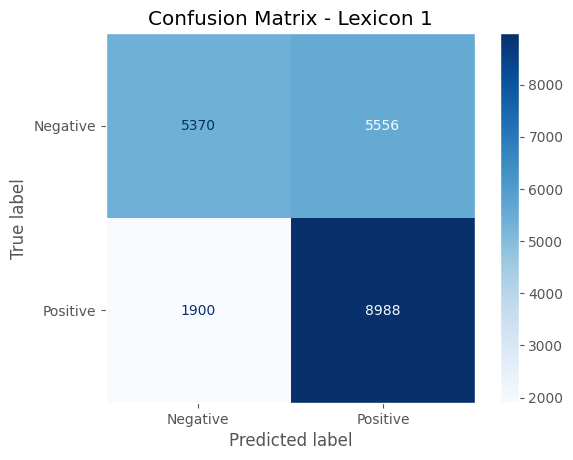

Lexicon 1 - Classification Report
Accuracy: 65.8%
Precision: 61.8%
Recall: 82.5%
F1 Score: 70.7%


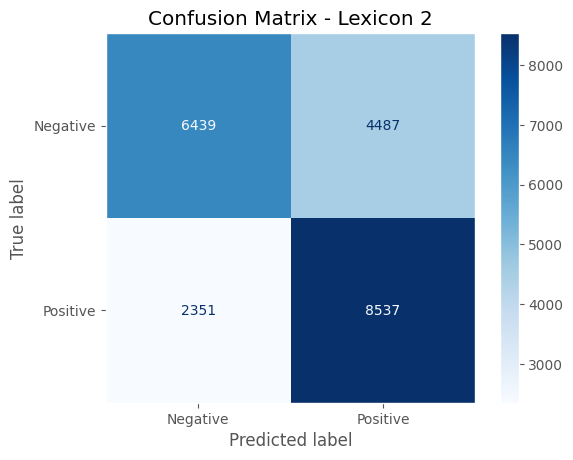

Lexicon 2 - Classification Report
Accuracy: 68.7%
Precision: 65.5%
Recall: 78.4%
F1 Score: 71.4%


In [333]:
# Generate the confusion matrix and classification report
#Lexicon 1
results_L1 = ConfMatrix('Lexicon 1',test_df['label'], test_df['L1'])
print("Lexicon 1 - Classification Report")
print("Accuracy: {:.1f}%".format(results_L1['accuracy'] * 100))
print("Precision: {:.1f}%".format(results_L1['1']['precision'] * 100))
print("Recall: {:.1f}%".format(results_L1['1']['recall'] * 100))
print("F1 Score: {:.1f}%".format(results_L1['1']['f1-score'] * 100))

#Lexicon 2
results_L2 = ConfMatrix('Lexicon 2',test_df['label'], test_df['L2'])
print("Lexicon 2 - Classification Report")
print("Accuracy: {:.1f}%".format(results_L2['accuracy'] * 100))
print("Precision: {:.1f}%".format(results_L2['1']['precision'] * 100))
print("Recall: {:.1f}%".format(results_L2['1']['recall'] * 100))
print("F1 Score: {:.1f}%".format(results_L2['1']['f1-score'] * 100))

### Com tratamento de negação

In [334]:
res_l1_test_neg = senti_no(test_df['Tokens Clean Neg'], lex1)
res_l2_test_neg = senti_no(test_df['Tokens Clean Neg'], lex2)

In [335]:
test_df['L1_Neg'] = (res_l1_test_neg)
test_df['L1_Neg'] = test_df['L1_Neg'].astype(int)
test_df['L2_Neg'] = (res_l2_test_neg)
test_df['L2_Neg'] = test_df['L2_Neg'].astype(int)

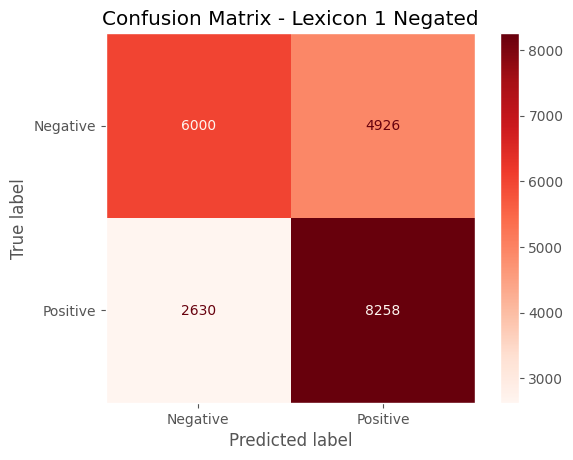

Lexicon 1 Negated - Classification Report
Accuracy: 65.4%
Precision: 62.6%
Recall: 75.8%
F1 Score: 68.6%


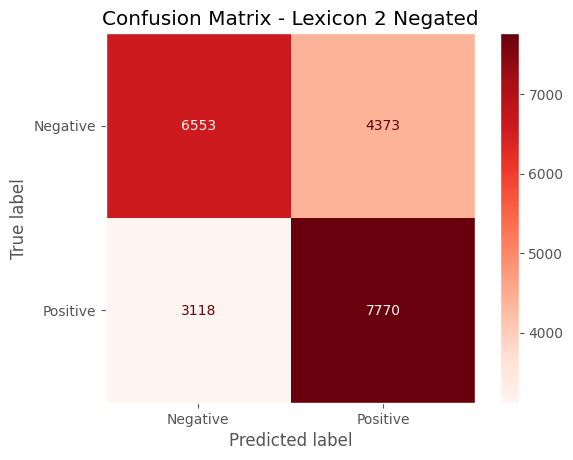

Lexicon 1 Negated - Classification Report
Accuracy: 65.7%
Precision: 64.0%
Recall: 71.4%
F1 Score: 67.5%


In [337]:
#Lexicon 1 Negated
results_L1_Neg = ConfMatrix('Lexicon 1 Negated',test_df['label'], test_df['L1_Neg'])
print("Lexicon 1 Negated - Classification Report")
print("Accuracy: {:.1f}%".format(results_L1_Neg['accuracy'] * 100))
print("Precision: {:.1f}%".format(results_L1_Neg['1']['precision'] * 100))
print("Recall: {:.1f}%".format(results_L1_Neg['1']['recall'] * 100))
print("F1 Score: {:.1f}%".format(results_L1_Neg['1']['f1-score'] * 100))

#Lexicon 2 Negated
results_L2_Neg = ConfMatrix('Lexicon 2 Negated',test_df['label'], test_df['L2_Neg'])
print("Lexicon 1 Negated - Classification Report")
print("Accuracy: {:.1f}%".format(results_L2_Neg['accuracy'] * 100))
print("Precision: {:.1f}%".format(results_L2_Neg['1']['precision'] * 100))
print("Recall: {:.1f}%".format(results_L2_Neg['1']['recall'] * 100))
print("F1 Score: {:.1f}%".format(results_L2_Neg['1']['f1-score'] * 100))

## With fine-tuning - Domain adaptation

In [354]:
def fine_tuning (df,lex,dict):
    lex_dict = lex.set_index(['English'])[['Correct_Sentiment']].to_dict(orient='index')
    senti_score = []
    og_score=[]

    for doc in df:
        t_s = 0
        processed_words = set()
        for word in doc:
            if word in lex_dict:
                processed_words.add(word)
                t_s += lex_dict[word]['Correct_Sentiment']
            elif word.startswith("NOT_"):
                negated_word = word[4:]
                if negated_word in lex_dict:
                    processed_words.add(word)
                    t_s -= lex_dict[negated_word]['Correct_Sentiment']
                else: 
                    if word in dict:
                        # Check if the word is in the dictionary
                        if dict[word]['sentiment'] == 'positive':
                            t_s -= 1
                        elif dict[word]['sentiment'] == 'negative':
                            t_s += 1

            else:
                # Look for it's sentiment in dictionary from train_df
                if word in dict:
                    if dict[word]['sentiment'] == 'positive':
                        t_s += 1
                    elif dict[word]['sentiment'] == 'negative':
                        t_s -= 1
        
        # Append the sentiment label, based on the total score
        og_score.append(t_s)
        if t_s > 0:
            senti_score.append('1')
        else:
            senti_score.append('0')
    return senti_score,og_score

### Sem tratamento da negação

In [377]:
ft_L1,score_neg_FT_L1 = fine_tuning(test_df['Tokens Clean'], lex1, dict_lex1)
ft_L2,score_neg_FT_L2 = fine_tuning(test_df['Tokens Clean'], lex2, dict_lex2)

In [378]:
test_df['FT_L1'] = (ft_L1)
test_df['FT_L1'] = test_df['FT_L1'].astype(int)

test_df['FT_L2'] = (ft_L2)
test_df['FT_L2'] = test_df['FT_L1'].astype(int)

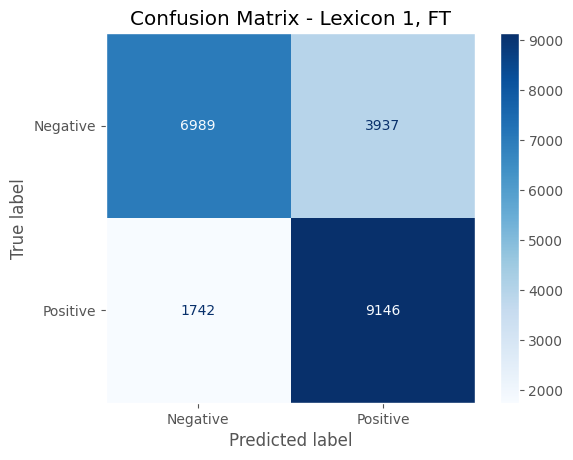

Lexicon 1 w/ Fine Tuning - Classification Report
Accuracy: 74.0%
Precision: 69.9%
Recall: 84.0%
F1 Score: 76.3%


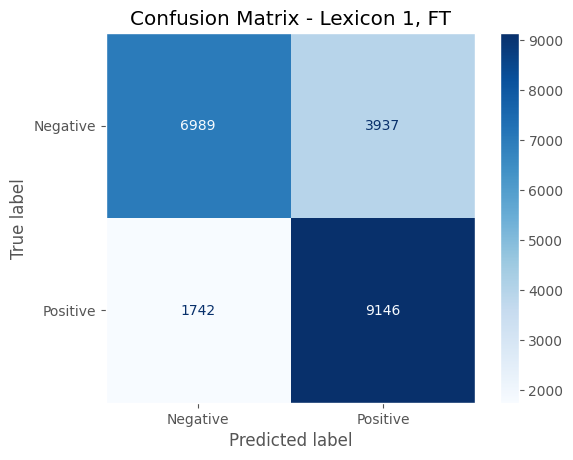

Lexicon 1 w/ Fine Tuning - Classification Report
Accuracy: 74.0%
Precision: 69.9%
Recall: 84.0%
F1 Score: 76.3%


In [379]:
# Lexicon 1 w/ fine tuning
results_ft_L1 = ConfMatrix('Lexicon 1, FT',test_df['label'], test_df['FT_L1'])
print("Lexicon 1 w/ Fine Tuning - Classification Report")
print("Accuracy: {:.1f}%".format(results_ft_L1['accuracy'] * 100))
print("Precision: {:.1f}%".format(results_ft_L1['1']['precision'] * 100))
print("Recall: {:.1f}%".format(results_ft_L1['1']['recall'] * 100))
print("F1 Score: {:.1f}%".format(results_ft_L1['1']['f1-score'] * 100))

# Lexicon 2 w/ fine tuning
results_ft_L2 = ConfMatrix('Lexicon 1, FT',test_df['label'], test_df['FT_L2'])
print("Lexicon 1 w/ Fine Tuning - Classification Report")
print("Accuracy: {:.1f}%".format(results_ft_L2['accuracy'] * 100))
print("Precision: {:.1f}%".format(results_ft_L2['1']['precision'] * 100))
print("Recall: {:.1f}%".format(results_ft_L2['1']['recall'] * 100))
print("F1 Score: {:.1f}%".format(results_ft_L2['1']['f1-score'] * 100))

### Com tratamento da negação

In [369]:
ft_neg_L1,score_neg_FT_L1 = fine_tuning(test_df['Tokens Clean Neg'], lex1, dict_lex1)
ft_neg_L2,score_neg_FT_L2 = fine_tuning(test_df['Tokens Clean Neg'], lex2, dict_lex2)

In [372]:
test_df['FT_Neg_L1'] = (ft_neg_L1)
test_df['FT_Neg_L1'] = test_df['FT_Neg_L1'].astype(int)

test_df['FT_Neg_L2'] = (ft_neg_L2)
test_df['FT_Neg_L2'] = test_df['FT_Neg_L2'].astype(int)

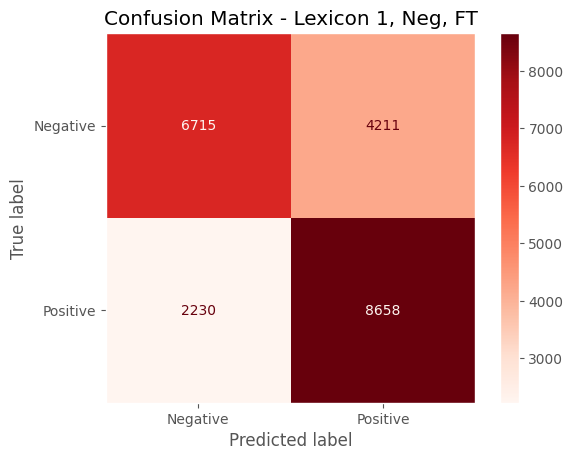

Lexicon 1 w/ Negation and Fine Tuning - Classification Report
Accuracy: 70.5%
Precision: 67.3%
Recall: 79.5%
F1 Score: 72.9%


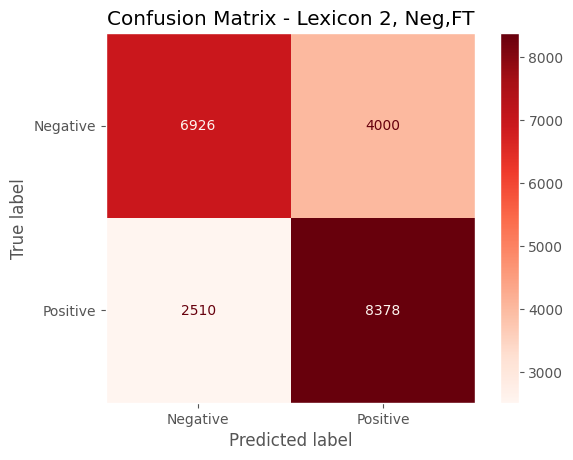

Lexicon 2 w/ Negation and Fine Tuning - Classification Report
Accuracy: 70.2%
Precision: 67.7%
Recall: 76.9%
F1 Score: 72.0%


In [ ]:
# Lexicon 1 w/ negation and fine tuning
results_neg_ft_L1 = ConfMatrix('Lexicon 1, Neg, FT',test_df['label'], test_df['FT_Neg_L1'])
print("Lexicon 1 w/ Negation and Fine Tuning - Classification Report")
print("Accuracy: {:.1f}%".format(results_neg_ft_L1['accuracy'] * 100))
print("Precision: {:.1f}%".format(results_neg_ft_L1['1']['precision'] * 100))
print("Recall: {:.1f}%".format(results_neg_ft_L1['1']['recall'] * 100))
print("F1 Score: {:.1f}%".format(results_neg_ft_L1['1']['f1-score'] * 100))

# Lexicon 2 w/ negation and fine tuning
results_neg_ft_L2 = ConfMatrix('Lexicon 2, Neg,FT',test_df['label'], test_df['FT_Neg_L2'])
print("Lexicon 2 w/ Negation and Fine Tuning - Classification Report")
print("Accuracy: {:.1f}%".format(results_neg_ft_L2['accuracy'] * 100))
print("Precision: {:.1f}%".format(results_neg_ft_L2['1']['precision'] * 100))
print("Recall: {:.1f}%".format(results_neg_ft_L2['1']['recall'] * 100))
print("F1 Score: {:.1f}%".format(results_neg_ft_L2['1']['f1-score'] * 100))